# Import libraries

In [1]:
# others 
import os, sys
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from google.colab import drive

#keras 
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model, Input, load_model
from keras import layers, regularizers, callbacks, optimizers, applications
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, EarlyStopping



Using TensorFlow backend.


# Connect to Drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Read dataset from Drive & Colab Notebook

In [3]:
dataset_train = '/content/drive/My Drive/Colab Notebooks/dataset/train'
dataset_test = '/content/drive/My Drive/Colab Notebooks/dataset/test'

# Generate batches for the images

In [4]:
train_datagen = ImageDataGenerator(
                                    rescale = 1. / 255,\
                                    zoom_range=0.1,\
                                    rotation_range=10,\
                                    width_shift_range=0.1,\
                                    height_shift_range=0.1,\
                                    horizontal_flip=True,\
                                    vertical_flip=False
                                   )

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=dataset_train, 
    target_size=(100, 100), #we needed to standarize the images for training
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    )

test_generator = test_datagen.flow_from_directory(
    directory=dataset_test, # we go to train directory 
    target_size=(100, 100), # and resize the images 256 by 256
    batch_size=64, # we are feeding images by batch size of 64
    class_mode='categorical'
    )

classnames = [k for k,v in train_generator.class_indices.items()]
print("Classes are: %r" %classnames)

Found 3733 images belonging to 5 classes.
Found 669 images belonging to 5 classes.
Classes are: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


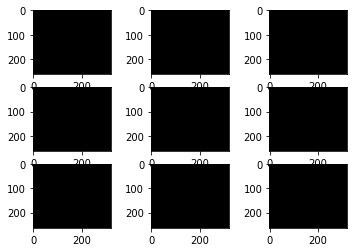

In [6]:
img = load_img('/content/drive/My Drive/Colab Notebooks/dataset/test/daisy/100080576_f52e8ee070_n.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = test_datagen
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [7]:
# CNN 
model = Sequential()

model.add(Conv2D(filters=32, activation='relu', kernel_size=(5,5), input_shape=(100, 100, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2))) #after max pooling we will have 127x127x3

model.add(Conv2D(filters=64, activation='relu', kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2,2))) #after max pooling we will have 62x62x3

model.add(Conv2D(filters=128, activation='relu', kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #after max pooling we will have 30x30x3

model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(units=128, activation='relu')) #, kernel_regularizer=l2(0.001)
model.add(Dropout(rate=0.5))

model.add(Dense(units=96, activation='relu'))
model.add(Dropout(rate=0.5)) #it is not good to use dropout before output 

model.add(Dense(units=5, activation='softmax'))
#loss is negative - the solution is to use Dense(n_classes, activation='softmax')



In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)            

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])

In [10]:
def lr_scheduler(epoch, lr):
    if epoch < 50:
        lr = 0.1
        return lr
    elif epoch > 50 and epoch < 80:
        lr=0.01
        return lr
    elif epoch > 80:
        lr = 0.001
        return lr
    return lr

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience=20)
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]
history = model.fit_generator(train_generator,\
                              steps_per_epoch=100, \
                              epochs=200,\
                              #callbacks=callbacks,\
                              validation_data=test_generator,\
                              validation_steps=100) 

Epoch 1/200
100/100 [==============================] - 846s 8s/step - loss: 1.6012 - accuracy: 0.2487 - val_loss: 1.6542 - val_accuracy: 0.0000e+00
Epoch 2/200
100/100 [==============================] - 198s 2s/step - loss: 1.5819 - accuracy: 0.2780 - val_loss: 1.6491 - val_accuracy: 0.0541
Epoch 3/200
100/100 [==============================] - 199s 2s/step - loss: 1.5456 - accuracy: 0.3123 - val_loss: 1.5726 - val_accuracy: 0.1025
Epoch 4/200
100/100 [==============================] - 209s 2s/step - loss: 1.4608 - accuracy: 0.3624 - val_loss: 1.3801 - val_accuracy: 0.3119
Epoch 5/200
 82/100 [=======================>......] - ETA: 26s - loss: 1.3926 - accuracy: 0.3864

# Plottings for CNN

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate_generator(test_generator,steps=100)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

In [ ]:
loss_train, acc_train = model.evaluate_generator(train_generator,steps=100)
print('Train loss: %f' %loss_train)
print('Train accuracy: %f' %acc_train)

# Pretrained models 

In [ ]:
pretrained_models = applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [ ]:
pretrained_models.summary()

In [ ]:
x = pretained_models.output
x = Flatten()(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(rate=0.4)(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(rate=0.4)(x)
x = Dense(40, activation="relu")(x)
x = BatchNormalization(axis=-1)(x)
predictions = Dense(units=5, activation="softmax")(x)

model_final = Model(inputs = pretained_models.input, outputs = predictions)

In [ ]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.001, nesterov=True), metrics=["accuracy"])

In [ ]:
model_final.summary()

In [ ]:
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]
history_pretained = model_final.fit_generator(
                                  train_generator,\
                                  steps_per_epoch=train_generator.n//train_generator.batch_size,\
                                  epochs=200,\
                                  callbacks=callbacks,\
                                  validation_data=test_generator,\
                                  validation_steps=test_generator.n//test_generator.batch_size
                                  )

In [ ]:
loss_pretrained, acc_pretrained = model_final.evaluate_generator(test_generator,steps=54)
print('Test loss: %f' %loss_pretrained)
print('Test accuracy: %f' %acc_pretrained)

loss_pretrained_train, acc_pretrained_train = model_final.evaluate_generator(train_generator,steps=54)
print('Train loss: %f' %loss_pretrained_train)
print('Train accuracy: %f' %acc_pretrained)

In [ ]:
# summarize history for accuracy
plt.plot(history_pretained.history['accuracy'])
plt.plot(history_pretained.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretained.history['loss'])
plt.plot(history_pretained.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()